# Task 2

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

### prob = [0.0243, 0.0811, 0.1105, 0.389]

In [3]:
# Parameter assumptions
num_periods = 10
num_names = 100
corr_coeff = 0.05 

def generate_corr_matrix(num_names, corr_coeff):
    corr_matrix = np.ones((num_names, num_names)) * corr_coeff
    np.fill_diagonal(corr_matrix, 1)
    return corr_matrix

# Generate correlation matrix
corr_matrix = generate_corr_matrix(num_names, corr_coeff)

def simulate_defaults_gaussian_copula(corr_matrix, num_periods, num_names, prob):
    defaults = np.zeros((num_periods, num_names), dtype=bool)
    remaining_names = np.arange(num_names)  # Initialize all names as remaining
    
    for t in range(num_periods):
        if t == 0:
            for i in range(num_names):
                group_index = i // (num_names // len(prob))  # Divide names into groups based on number of probabilities
                defaults[t, i] = np.random.rand() > (1 - prob[group_index])  # Assign default probability based on group
            remaining_names = np.where(defaults[t] == 0)[0]  # Update remaining names
        else:
            prev_defaults = defaults[t-1]
            prev_defaults_corr = prev_defaults.reshape(-1, 1) @ prev_defaults.reshape(1, -1)
            corr_matrix_remaining = corr_matrix * (1 - prev_defaults_corr)
            for i in range(len(remaining_names)):
                group_index = remaining_names[i] // (num_names // len(prob))  # Determine group index
                prob_default = prob[group_index]  # Get default probability for the group
                corr_row = corr_matrix_remaining[remaining_names[i]]
                defaults[t, remaining_names[i]] = np.random.rand() > (1 - prob_default)
            defaulted_names = np.where(defaults[t])[0]
            remaining_names = np.setdiff1d(remaining_names, defaulted_names)  # Remove defaulted names
    return defaults

# Define probabilities for different groups
prob = [0.0243, 0.0811, 0.1105, 0.389]

# Simulate defaults with different default probabilities
defaults_gaussian_copula = simulate_defaults_gaussian_copula(corr_matrix, num_periods, num_names, prob)

In [4]:
def simulate_defaults_period_by_period(corr_matrix, num_periods, num_names, prob):
    defaults = np.zeros((num_periods, num_names), dtype=bool)
    defaulted_names = set()
    
    for t in range(num_periods):
        if t == 0:
            for i in range(num_names):
                group_index = i // (num_names // len(prob))  # Divide names into groups based on number of probabilities
                defaults[t, i] = np.random.rand() > (1 - prob[group_index])  # Assign default probability based on group
            defaulted_names.update(set(np.where(defaults[t])[0]))
        else:
            remaining_names = np.array(list(set(range(num_names)) - defaulted_names))
            if len(remaining_names) == 0:
                break  # If all names have defaulted, stop simulation
            
            corr_matrix_remaining = corr_matrix[remaining_names][:, remaining_names]
            
            for i in range(len(remaining_names)):
                if defaults[t-1, remaining_names[i]]:
                    continue  # Skip defaulted names
                corr_row = corr_matrix_remaining[i]
                group_index = remaining_names[i] // (num_names // len(prob))  # Determine group index
                prob_default = prob[group_index]  # Get default probability for the group
                defaults[t, remaining_names[i]] = np.random.rand() > (1 - prob_default)
                if defaults[t, remaining_names[i]]:
                    defaulted_names.add(remaining_names[i])
    return defaults

# Define probabilities for different groups
prob = [0.0243, 0.0811, 0.1105, 0.389]

# Simulate defaults with different default probabilities
defaults_period_by_period = simulate_defaults_period_by_period(corr_matrix, num_periods, num_names, prob)

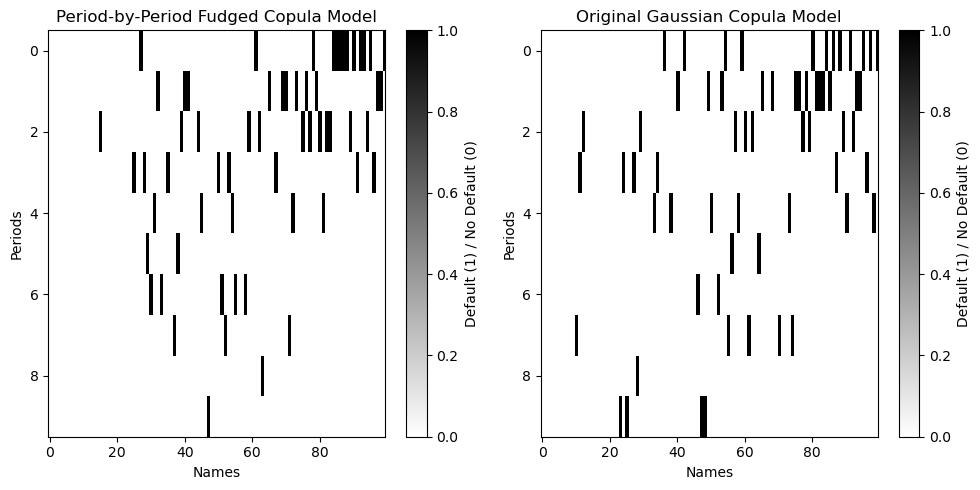

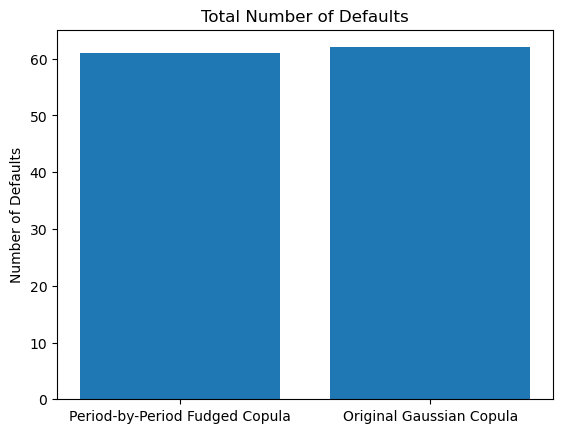

In [5]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(defaults_period_by_period, cmap='binary', aspect='auto')
plt.title('Period-by-Period Fudged Copula Model')
plt.xlabel('Names')
plt.ylabel('Periods')
plt.colorbar(label='Default (1) / No Default (0)')

plt.subplot(1, 2, 2)
plt.imshow(defaults_gaussian_copula, cmap='binary', aspect='auto')
plt.title('Original Gaussian Copula Model')
plt.xlabel('Names')
plt.ylabel('Periods')
plt.colorbar(label='Default (1) / No Default (0)')

plt.tight_layout()
plt.show()

# Calculate total number of defaults for each approach
total_defaults_period_by_period = np.sum(defaults_period_by_period)
total_defaults_gaussian_copula = np.sum(defaults_gaussian_copula)

# Plotting
plt.bar(['Period-by-Period Fudged Copula', 'Original Gaussian Copula'], 
        [total_defaults_period_by_period, total_defaults_gaussian_copula])
plt.title('Total Number of Defaults')
plt.ylabel('Number of Defaults')
plt.show()

In [6]:
def generate_loss_distribution(defaults, lgd, outstanding_balance):
    num_periods, num_names = defaults.shape
    losses = np.zeros(num_periods)
    
    for t in range(num_periods):
        defaulted_indices = np.where(defaults[t])[0]
        loss_amounts = np.zeros_like(defaults[t], dtype=float)
        
        for idx in defaulted_indices:
            loss_amounts[idx] = lgd[idx] * outstanding_balance[idx]
        
        losses[t] = np.sum(loss_amounts)
    
    cumulative_losses = np.cumsum(losses)
    return cumulative_losses

# Example parameters
lgd = np.random.uniform(low=0.1, high=0.5, size=num_names)  # Example LGD values for each name
outstanding_balance = np.random.uniform(low=100000, high=1000000, size=num_names)  # Example outstanding balances for each name

# Generate loss distribution for period-by-period approach
loss_distribution_period_by_period = generate_loss_distribution(defaults_period_by_period, lgd, outstanding_balance)

# Generate loss distribution for Gaussian copula approach
loss_distribution_gaussian_copula = generate_loss_distribution(defaults_gaussian_copula, lgd, outstanding_balance)

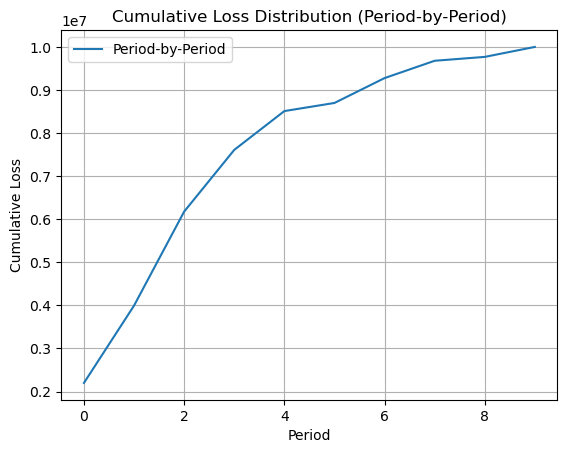

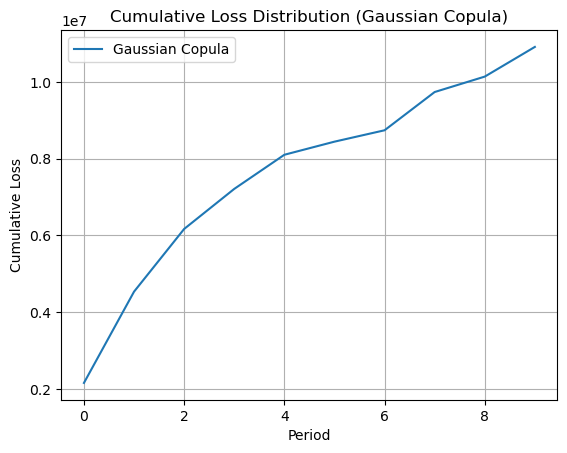

In [7]:
# Plot loss distribution for period-by-period approach
plt.plot(loss_distribution_period_by_period, label='Period-by-Period')
plt.xlabel('Period')
plt.ylabel('Cumulative Loss')
plt.title('Cumulative Loss Distribution (Period-by-Period)')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss distribution for Gaussian copula approach
plt.plot(loss_distribution_gaussian_copula, label='Gaussian Copula')
plt.xlabel('Period')
plt.ylabel('Cumulative Loss')
plt.title('Cumulative Loss Distribution (Gaussian Copula)')
plt.legend()
plt.grid(True)
plt.show()

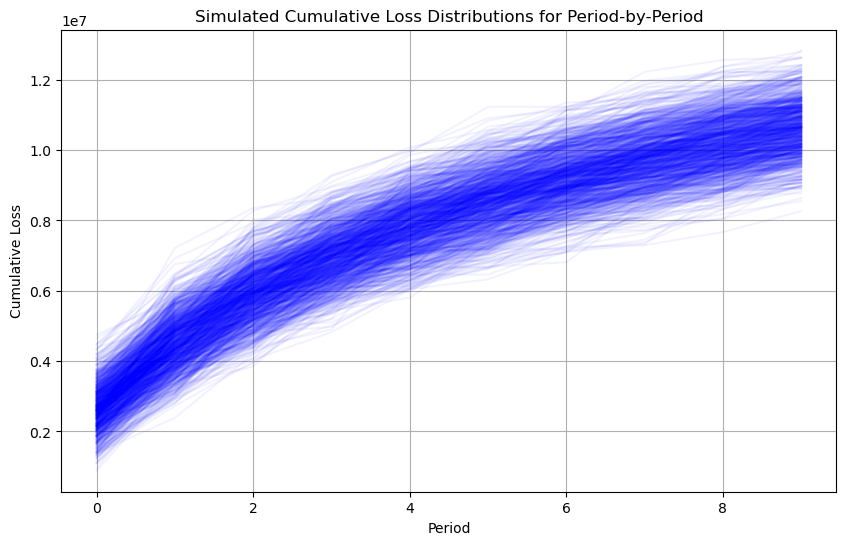

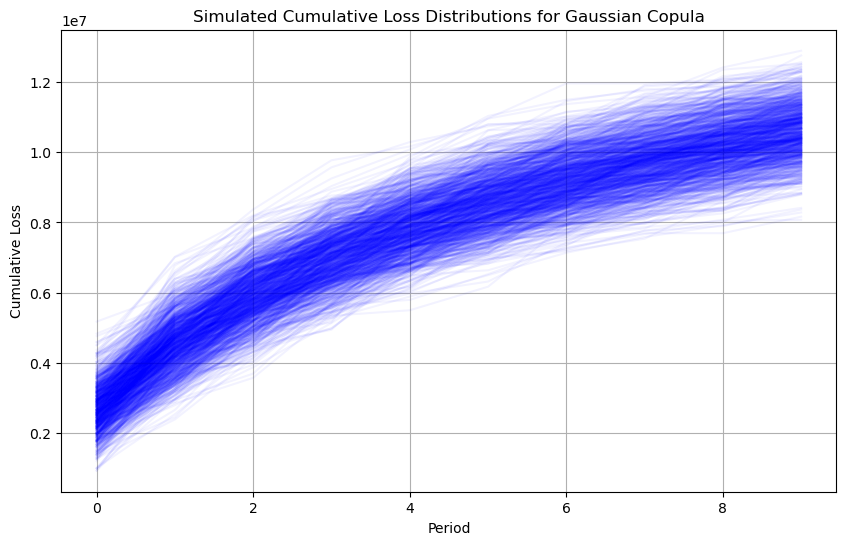

In [9]:
def simulate_loss_distribution_period(simulations, corr_matrix, num_periods, num_names, lgd, outstanding_balance, prob):
    loss_distributions_period = []
    
    for _ in range(simulations):
        # Simulate defaults using Gaussian copula approach
        defaults = simulate_defaults_period_by_period(corr_matrix, num_periods, num_names, prob)
        
        # Generate loss distribution for the current simulation
        loss_distribution_period = generate_loss_distribution(defaults, lgd, outstanding_balance)
        
        # Append the loss distribution to the list
        loss_distributions_period.append(loss_distribution_period)
    
    return loss_distributions_period


# Parameters
simulations = 1000  # Number of simulations

# Simulate loss distribution
last_losses = simulate_loss_distribution(simulations, corr_matrix, num_periods, num_names, lgd, outstanding_balance, prob)

# Plot histogram of last losses
plt.hist(last_losses, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Last Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Last Losses')
plt.grid(True)
plt.show()

def simulate_loss_distribution_gaussian(simulations, corr_matrix, num_periods, num_names, lgd, outstanding_balance, prob):
    loss_distributions_gaussian = []
    
    for _ in range(simulations):
        # Simulate defaults using Gaussian copula approach
        defaults = simulate_defaults_gaussian_copula(corr_matrix, num_periods, num_names, prob)
        
        # Generate loss distribution for the current simulation
        loss_distribution_gaussian = generate_loss_distribution(defaults, lgd, outstanding_balance)
        
        # Append the loss distribution to the list
        loss_distributions_gaussian.append(loss_distribution_gaussian)
    
    return loss_distributions_gaussian


# Parameters
simulations = 1000  # Number of simulations

# Simulate loss distribution
loss_distributions_period = simulate_loss_distribution_period(simulations, corr_matrix, num_periods, num_names, lgd, outstanding_balance, prob)
loss_distributions_gaussian = simulate_loss_distribution_gaussian(simulations, corr_matrix, num_periods, num_names, lgd, outstanding_balance, prob)

# Plot loss distributions

plt.figure(figsize=(10, 6))
for i, loss_dist in enumerate(loss_distributions_period):
    plt.plot(loss_dist, color='blue', alpha=0.05)

plt.xlabel('Period')
plt.ylabel('Cumulative Loss')
plt.title('Simulated Cumulative Loss Distributions for Period-by-Period')
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
for i, loss_dist in enumerate(loss_distributions_gaussian):
    plt.plot(loss_dist, color='blue', alpha=0.05)

plt.xlabel('Period')
plt.ylabel('Cumulative Loss')
plt.title('Simulated Cumulative Loss Distributions for Gaussian Copula')
plt.grid(True)
plt.show()

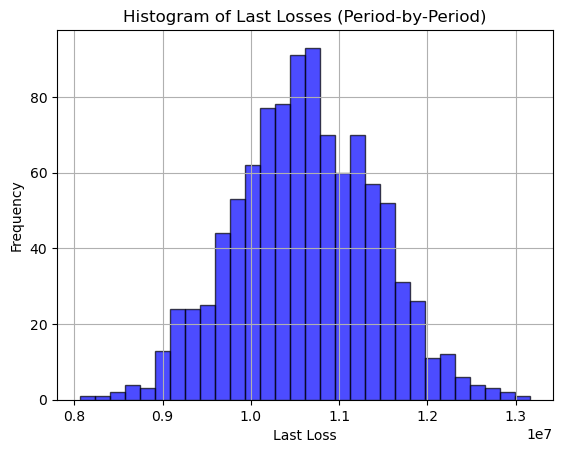

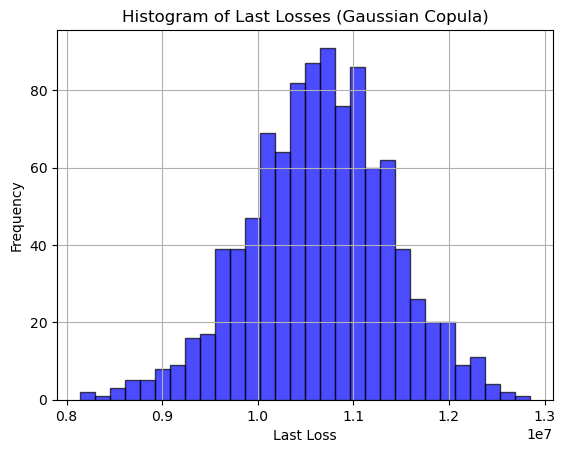

In [21]:
def simulate_loss_distribution_period(simulations, corr_matrix, num_periods, num_names, lgd, outstanding_balance, prob):
    last_losses_period = []
    
    for _ in range(simulations):
        # Simulate defaults using period-by-period approach
        defaults = simulate_defaults_period_by_period(corr_matrix, num_periods, num_names, prob)
        
        # Generate loss distribution for the current simulation
        loss_distribution_period = generate_loss_distribution(defaults, lgd, outstanding_balance)
        
        # Get the last loss from the distribution
        last_loss = loss_distribution_period[-1]
        
        # Append the last loss to the list
        last_losses_period.append(last_loss)
    
    return last_losses_period

def simulate_loss_distribution_gaussian(simulations, corr_matrix, num_periods, num_names, lgd, outstanding_balance, prob):
    last_losses_gaussian = []
    
    for _ in range(simulations):
        # Simulate defaults using Gaussian copula approach
        defaults = simulate_defaults_gaussian_copula(corr_matrix, num_periods, num_names, prob)
        
        # Generate loss distribution for the current simulation
        loss_distribution_gaussian = generate_loss_distribution(defaults, lgd, outstanding_balance)
        
        # Get the last loss from the distribution
        last_loss = loss_distribution_gaussian[-1]
        
        # Append the last loss to the list
        last_losses_gaussian.append(last_loss)
    
    return last_losses_gaussian

simulations = 1000  # Number of simulations

# Simulate last losses for period-by-period approach
last_losses_period = simulate_loss_distribution_period(simulations, corr_matrix, num_periods, num_names, lgd, outstanding_balance, prob)

# Plot histogram of last losses for period-by-period approach
plt.hist(last_losses_period, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Last Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Last Losses (Period-by-Period)')
plt.grid(True)
plt.show()

# Simulate last losses for Gaussian copula approach
last_losses_gaussian = simulate_loss_distribution_gaussian(simulations, corr_matrix, num_periods, num_names, lgd, outstanding_balance, prob)

# Plot histogram of last losses for Gaussian copula approach
plt.hist(last_losses_gaussian, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Last Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Last Losses (Gaussian Copula)')
plt.grid(True)
plt.show()

In [22]:
np.mean(last_losses_period)

10616075.439113554

In [23]:
np.mean(last_losses_gaussian)

10644672.770536523